## Assignment 1

The names and usernames have been given codes to avoid any privacy concerns.

Columns:
<li>Location
<li>Tweet At
<li>Original Tweet
<li>Label

In [1]:
#Entry point to programming Spark with the Dataset and DataFrame API.
from pyspark.sql import SparkSession

#Garbage Collector
import gc
gc.collect()

117

In [2]:
#Run the session
spark = SparkSession.builder.appName('nlp').getOrCreate()

In [3]:
#read the data
df=spark.read.csv("Corona_NLP1.csv", header=True)

In [4]:
#data columns and rows
df.show()

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|            UserName|          ScreenName|            Location|           Sentiment|   TweetAt|       OriginalTweet|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|                3799|               48751|              London|             Neutral|16-03-2020|@MeNyrbie @Phil_G...|
|                3800|               48752|                  UK|            Positive|16-03-2020|advice Talk to yo...|
|                3801|               48753|           Vagabonds|            Positive|16-03-2020|Coronavirus Austr...|
|                3802|               48754|                null|            Positive|16-03-2020|My food stock is ...|
|              PLEASE|         don't panic| THERE WILL BE EN...|                null|      null|                null|
|           Stay calm|          stay safe.|             

### Data Exploration & Pre-Processing

In [6]:
#Check for duplicates and null values

df=df.dropDuplicates()
print(df.count(),",", len(df.columns))
df=df.na.drop()
print(df.count(),",", len(df.columns))

65074 , 6
32621 , 6


In [7]:
#Drop irrelevant columns
df=df.drop('UserName','ScreenName')
print(df.count(),",", len(df.columns))

32621 , 4


In [8]:
#Column Description

df.printSchema()

root
 |-- Location: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- TweetAt: string (nullable = true)
 |-- OriginalTweet: string (nullable = true)



In [9]:
#Data summary
df.summary().show()

+-------+--------------------+--------------------+--------------------+--------------------+
|summary|            Location|           Sentiment|             TweetAt|       OriginalTweet|
+-------+--------------------+--------------------+--------------------+--------------------+
|  count|               32621|               32621|               32621|               32621|
|   mean|1.841671215583333...|                null|                null|               682.0|
| stddev|9.022286250346791E10|                null|                null|  1176.0629234866644|
|    min|                    |      #EmergencyKits|        Toilet Paper|      Coronavirus...|
|    25%|               501.0|                null|                null|                 2.0|
|    50%|              2748.0|                null|                null|                 4.0|
|    75%|             34787.0|                null|                null|              2040.0|
|    max|ï? ???????'? ????...|the lives of peop...|roasted c

In [11]:
df.columns

['Location', 'Sentiment', 'TweetAt', 'OriginalTweet']

In [12]:
li=['Positive','Negative','Neutral','Extremely Positive','Extremely Negative']
df=df.filter(df.Sentiment.isin(li))

In [13]:
dff = df.toPandas()

In [14]:
import pandas as pd

In [15]:
dff.head()
dff.describe(include='all')

,Location,Sentiment,TweetAt,OriginalTweet
count,32561,32561,32561,32561
unique,12214,5,30,32470
top,London,Positive,20-03-2020,@ssupnow 1.Sanitizer
freq,540,9109,2617,9


In [16]:
dff['Sentiment'].value_counts()

Positive              9109
Negative              7762
Neutral               6171
Extremely Positive    5272
Extremely Negative    4247
Name: Sentiment, dtype: int64

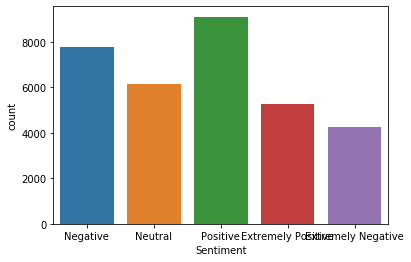

In [17]:
#Sentiment Distribution

ax = sns.countplot(x="Sentiment", data=dff)
ax

In [44]:
#Handling class imbalance with SMOTE

def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver/100
    for i in range(nt):
        for j in range(nexs):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = sc.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)

In [ ]:
ss=SmoteSampling(vectorizerFunction(df, 'Y'), k = 2, minorityClass = 1, majorityClass = 0, percentageOver = 90, percentageUnder = 5)

In [18]:
#Location Distribution

dff['Location'].value_counts()

London                                                                  540
United States                                                           528
London, England                                                         520
New York, NY                                                            395
Washington, DC                                                          373
United Kingdom                                                          337
Los Angeles, CA                                                         281
India                                                                   268
UK                                                                      232
Australia                                                               225
USA                                                                     223
Canada                                                                  191
England, United Kingdom                                                 191
Toronto, Ont

In [23]:
#Length of Tweets and average length wrt to sentiments

from pyspark.sql.functions import length
df=df.withColumn('length', length(df['OriginalTweet']))
df.show()
df.groupby('Sentiment').mean().show()

+--------------------+------------------+----------+--------------------+------+
|            Location|         Sentiment|   TweetAt|       OriginalTweet|length|
+--------------------+------------------+----------+--------------------+------+
| ????? ???? ????????|          Negative|16-03-2020|#unpopularopinion...|   175|
|      Owensboro, KY |           Neutral|16-03-2020|Just online shopp...|    80|
|            New York|          Positive|16-03-2020|I know a lot of g...|   269|
|         Houston, TX|          Positive|17-03-2020|Our latest issue ...|   164|
|  Manchester, Europe|Extremely Positive|17-03-2020|If you are health...|   202|
|      Leeds, England|          Positive|17-03-2020|#COVID2019 local ...|   191|
|          upstate NY|          Negative|17-03-2020|Seeing those empt...|   181|
|          Texas, USA|          Positive|17-03-2020|Governor @GregAbb...|   120|
|          Dallas, TX|           Neutral|17-03-2020|U.S. retail sales...|   182|
|        Georgia, USA|      

In [24]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

ext_neg= dff[dff['Sentiment']=='Extremely Negative']['OriginalTweet'].str.len()
ext_pos= dff[dff['Sentiment']=='Extremely Positive']['OriginalTweet'].str.len()
neg= dff[dff['Sentiment']=='Negative']['OriginalTweet'].str.len()
pos= dff[dff['Sentiment']=='Positive']['OriginalTweet'].str.len()
neutral= dff[dff['Sentiment']=='Neutral']['OriginalTweet'].str.len()

fig= make_subplots(rows=2, cols= 3)

fig.add_trace(go.Histogram(x=list(neg), name='Negative Tweets'), row=1, col=1)
fig.add_trace(go.Histogram(x=list(pos), name='Positive Tweets'), row=1, col=2)
fig.add_trace(go.Histogram(x=list(neutral), name='Neutral Tweets'), row=1, col=3)
fig.add_trace(go.Histogram(x=list(ext_neg), name='ExtremelyNegative Tweets'), row=2, col=1)
fig.add_trace(go.Histogram(x=list(ext_pos), name='Extremely Positive Tweets'), row=2, col=2)

In [25]:
#Tokenization. Stop words removal, TF_IDF

import sparknlp
sparknlp.start()
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.sql.functions import lower, col, regexp_replace


tokenizer= Tokenizer(inputCol='OriginalTweet', outputCol= 'token_text')
stopremove= StopWordsRemover(inputCol='token_text', outputCol= 'stop_word')
count_vec= CountVectorizer(inputCol='stop_word', outputCol='c_vec')
idf= IDF(inputCol='c_vec',outputCol='tf_idf')

labels= StringIndexer(inputCol='Sentiment', outputCol='label')


In [26]:
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.linalg import Vector

In [27]:
cleanup=VectorAssembler(inputCols=['tf_idf','length'], outputCol='features')

In [28]:
from pyspark.ml import Pipeline
pipe= Pipeline(stages=[labels, tokenizer, stopremove, count_vec, idf, cleanup])

In [29]:
cleaner= pipe.fit(df).transform(df)

In [30]:
cleaner.show()

+--------------------+------------------+----------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|            Location|         Sentiment|   TweetAt|       OriginalTweet|length|label|          token_text|           stop_word|               c_vec|              tf_idf|            features|
+--------------------+------------------+----------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
| ????? ???? ????????|          Negative|16-03-2020|#unpopularopinion...|   175|  1.0|[#unpopularopinio...|[#unpopularopinio...|(80619,[5,56,60,8...|(80619,[5,56,60,8...|(80620,[5,56,60,8...|
|      Owensboro, KY |           Neutral|16-03-2020|Just online shopp...|    80|  2.0|[just, online, sh...|[online, shopping...|(80619,[6,13,14,8...|(80619,[6,13,14,8...|(80620,[6,13,14,8...|
|            New York|          Positive

In [31]:
cleaner.select(['features','label'])
cleaner.show()

+--------------------+------------------+----------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|            Location|         Sentiment|   TweetAt|       OriginalTweet|length|label|          token_text|           stop_word|               c_vec|              tf_idf|            features|
+--------------------+------------------+----------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
| ????? ???? ????????|          Negative|16-03-2020|#unpopularopinion...|   175|  1.0|[#unpopularopinio...|[#unpopularopinio...|(80619,[5,56,60,8...|(80619,[5,56,60,8...|(80620,[5,56,60,8...|
|      Owensboro, KY |           Neutral|16-03-2020|Just online shopp...|    80|  2.0|[just, online, sh...|[online, shopping...|(80619,[6,13,14,8...|(80619,[6,13,14,8...|(80620,[6,13,14,8...|
|            New York|          Positive

In [32]:
#spitting the dataset

(train,test)= cleaner.randomSplit([0.8,0.2])

### Model

In [37]:
#Using Naive Bayes Model for Multiclass classification

from pyspark.ml.classification import NaiveBayes as nb

nb= nb()

In [38]:
model= nb.fit(train)

In [39]:
pred= model.transform(test)

In [40]:
#Evaluating the model

from pyspark.ml.evaluation import MulticlassClassificationEvaluator as ML
evaluator= ML()
evaluator.evaluate(pred)

0.38027581406112076